In [151]:
import pandas as pd
import numpy as np
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')
tf.__version__

'1.13.1'

In [152]:
data = pd.read_csv('train.csv')
data.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [153]:
data = data.dropna()
x = data.drop('target', axis = 1)
y = data['target']
print(x.shape, y.shape)

(5080, 4) (5080,)


In [154]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.python.keras.layers import LSTM, Dense, Dropout, Bidirectional, GlobalMaxPool1D

In [155]:
vocab_size = 5000
sentence_length = 30
msg = x.copy()
msg.reset_index(inplace = True)

In [156]:
import re
import nltk
from nltk.corpus import stopwords

In [157]:
#Data Preprocessing
from nltk.stem.porter import PorterStemmer
porter_stem = PorterStemmer()
corpus = []
for i in range(0, len(msg)):
    rvw = re.sub('[^a-zA-z]', ' ', msg['text'][i])
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    rvw = emoji_pattern.sub('', msg['text'][i])
    url = re.compile(r'https?://\S+|www\.\S+')
    rvw = url.sub('', msg['text'][i])
    rvw = rvw.lower()
    rvw = rvw.split()
    rvw = [porter_stem.stem(word) for word in rvw if not word in stopwords.words('english')]
    rvw = ' '.join(rvw)
    corpus.append(rvw)

In [158]:
onehot = [one_hot(words, vocab_size) for words in corpus]

In [159]:
#Padding the onehot length because embedding layer requires sentences of equal length
embed_doc = pad_sequences(onehot, padding = 'pre', maxlen = sentence_length)
len(embed_doc)

5080

In [160]:
#Creating the model
embedding_vec_features = 128
model = Sequential()
model.add(Embedding(vocab_size, embedding_vec_features, input_length = sentence_length))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.3)))
model.add(GlobalMaxPool1D())
#Dense layer with sigmoid activation because this is a classification problem and we need 1 output
model.add(Dense(1, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 30, 128)           640000    
_________________________________________________________________
dropout_12 (Dropout)         (None, 30, 128)           0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 30, 128)           98816     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 738,945
Trainable params: 738,945
Non-trainable params: 0
_________________________________________________________________
None


In [161]:
import numpy as np
x_final = np.array(embed_doc)
y_final = np.array(y)
print(x_final.shape, y_final.shape)

(5080, 30) (5080,)


In [162]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_final, y_final, test_size = 0.1, random_state = 42)

In [163]:
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 5, batch_size = 8)

Train on 4572 samples, validate on 508 samples
Epoch 1/5
4572/4572 [==============================] - 58s 13ms/sample - loss: 0.5948 - acc: 0.6745 - val_loss: 0.4866 - val_acc: 0.7776
Epoch 2/5
4572/4572 [==============================] - 47s 10ms/sample - loss: 0.3991 - acc: 0.8268 - val_loss: 0.4955 - val_acc: 0.7854
Epoch 3/5
4572/4572 [==============================] - 45s 10ms/sample - loss: 0.3009 - acc: 0.8760 - val_loss: 0.5743 - val_acc: 0.7618
Epoch 4/5
4572/4572 [==============================] - 44s 10ms/sample - loss: 0.2291 - acc: 0.9151 - val_loss: 0.6140 - val_acc: 0.7717
Epoch 5/5
4572/4572 [==============================] - 45s 10ms/sample - loss: 0.1728 - acc: 0.9346 - val_loss: 0.7085 - val_acc: 0.7677


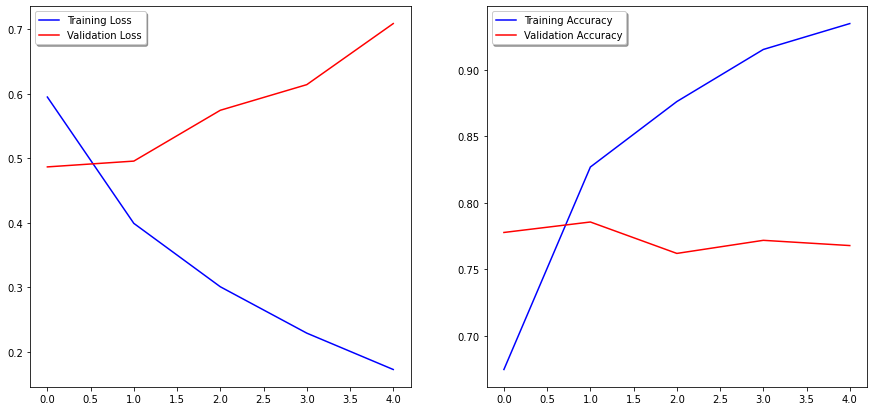

In [164]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))
ax1 = plt.subplot(1,2,1)
ax1.plot(history.history['loss'], color='b', label='Training Loss') 
ax1.plot(history.history['val_loss'], color='r', label = 'Validation Loss',axes=ax1)
legend = ax1.legend(loc='best', shadow=True)
ax2 = plt.subplot(1,2,2)
ax2.plot(history.history['acc'], color='b', label='Training Accuracy') 
ax2.plot(history.history['val_acc'], color='r', label = 'Validation Accuracy')
legend = ax2.legend(loc='best', shadow=True)

In [165]:
def test(X):
    X = X.fillna(0)
    messages = X.copy()
    messages.reset_index(inplace=True)
    testcorpus=[]
    
    for i in range(len(messages)):
        reviews=re.sub('[^a-zA-Z]',' ',str(messages['text'][i]))
        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        rvw = emoji_pattern.sub('', msg['text'][i])
        url = re.compile(r'https?://\S+|www\.\S+')
        rvw = url.sub('', msg['text'][i])
        reviews=reviews.lower()
        reviews=reviews.split()
        reviews=[porter_stem.stem(word) for word in reviews if word not in stopwords.words('english')]
        reviews=' '.join(reviews)
        testcorpus.append(reviews)
    one_hot_rep=[one_hot(word,vocab_size)for word in testcorpus]
    embedded_docs = pad_sequences(one_hot_rep, padding = 'pre', maxlen = sentence_length)
    X_final = np.array(embedded_docs)
    
    return X_final

In [ ]:
test_data = pd.read_csv('test.csv')
test_final = test(test_data)

In [ ]:
test_pred = model.predict(test_final)
test_pred.shape

In [ ]:
submission_data = pd.read_csv('sample_submission.csv')
submission_data['target']=np.round(test_pred).astype('int')
submission_data.to_csv('my_submission_third_9June.csv',index=False)